In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import hashlib
import json
from dbCon import PGCON
from datetime import datetime
import time

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Get data and use augmentation

In [2]:
trainPath = 'imageRepo/ISICArchive_v1/train_224_224'
validPath = 'imageRepo/ISICArchive_v1/validation_224_224'
testPath = 'imageRepo/ISICArchive_v1/test_224_224'

In [3]:
trainDataGen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
    vertical_flip=True,
    rotation_range=180
)
testDataGen = ImageDataGenerator(rescale=1./255)
validationDataGen = ImageDataGenerator(rescale=1./255)

In [4]:
seed = 443
trainBatches = trainDataGen.flow_from_directory(
    directory=trainPath, 
    target_size=(224,224), 
    classes=['benign', 'malignant'], 
    batch_size=32,
    seed=seed
)

validBatches = validationDataGen.flow_from_directory(
    directory=validPath, 
    target_size=(224,224), 
    classes=['benign', 'malignant'], 
    batch_size=32,
    seed=seed
)

testBatches = testDataGen.flow_from_directory(
    directory=testPath, 
    target_size=(224,224), 
    classes=['benign', 'malignant'], 
    batch_size=32, 
    shuffle=False,
    seed=seed
)
print("\nClass indices:")
print(trainBatches.class_indices)

Found 9142 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.
Found 1142 images belonging to 2 classes.

Class indices:
{'benign': 0, 'malignant': 1}


## Supporting functions for generating models with different hyperparameter settings and fine tuning parameters

In [5]:
def modelCreate(hyperParameters):
    """
    Takes hyperparameter values as input, and generates a compiled model as output.
    """
    
    #base_model = VGG16(include_top=False, input_shape=(224,224,3))
    base_model = InceptionV3(include_top=False, input_shape=(224,224,3))
    base_model.trainable = False
    #base_model.summary()
    model = Sequential()
    model.add(base_model)
  
    # Flatten the data
    model.add(Flatten())
    
    for k in range(1, hyperParameters['numberOfDenseLayerBlocks']+1):
        model.add(Dense(units=hyperParameters['numberOfDenseLayerUnitsPerBlock']))
        model.add(Dropout(hyperParameters['dropOutInDenseLayer']))
    
    # Add the final layer, classification
    model.add(Dense(units=2, activation='softmax'))
        
    model.compile(
        optimizer=Adam(learning_rate=hyperParameters['learningRate']), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [6]:
def modelFineTune(model, hyperParameters):
    """
    Take the model and hyperparameters as input,
    return the model with all layers unfrozen and the model compiled.
    """
    model.trainable = True
    
    model.compile(
        #optimizer=Adam(learning_rate=hyperParameters['learningRate']/5), 
        optimizer=Adam(learning_rate=hyperParameters['learningRate']/10), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
        
    return model

In [7]:
def getRandomHyperparameters(hyperparameters):
    """
    Takes a dict of hyperparameters and randomly chooses a set of parameters.
    """
    hyperParametersToUse = {}
    for hp, hpValues in hyperparameters.items():
        hyperParametersToUse[hp] = random.choice(hpValues)
    
    return hyperParametersToUse

In [8]:
def getHyperparameterSet(numberOfModels, hyperparameters):
    """
    
    """
    hyperparametersToUse = {}
    i = 0
    while i < numberOfModels:
        getHyperparameters = getRandomHyperparameters(hyperparameters)
        hpHash = hash(json.dumps(getHyperparameters, sort_keys=True))

        # Only keep this combination of hyperparameters if unique
        if not hpHash in hyperparametersToUse:
            hyperparametersToUse[hpHash] = getHyperparameters
            i += 1
    return hyperparametersToUse

In [9]:
# Set parameters for Random Search
hyperparameters = {}
hyperparameters['numberOfDenseLayerBlocks'] = [4]
hyperparameters['numberOfDenseLayerUnitsPerBlock'] = [512]
hyperparameters['dropOutInDenseLayer'] = [0.4, 0.5]
hyperparameters['learningRate'] = [0.0001]

# Pick hyperparameters to test
numberOfModels = 2
hyperparametersToUse = getHyperparameterSet(numberOfModels, hyperparameters)

## Train the models including fine tuning and store the result in a local database for evaluation, also stores the model itself

In [10]:
# Fit models and store result
nameOfTraining = "Fine tuning Inceptionv3 (LR:/10), augmentaion, tenth run"
numberOfEpochsInitial = 10
numberOfEpochsFineTune = 150 # EarlyStopping is used

for hpId, hpSettings in hyperparametersToUse.items():
    # Initial training of model
    try:
        # Create the model with frozen base_model layers
        model = modelCreate(hpSettings)
        model.summary()
        
        elapsedTime = 0
        timeStart = time.time()
        # Initial fit of model
        history = model.fit(trainBatches,
            steps_per_epoch=len(trainBatches),
            validation_data=validBatches,
            validation_steps=len(validBatches),
            epochs=numberOfEpochsInitial
        )
        elapsedTime = time.time() - timeStart
        print("Done initial training")
    except:
        print('Exception encountered, initial training')
        db = PGCON()
        numRows = db.insertRow("insert into californium.traininglogs (\"name\", \"data\", \"hyperparameters\") values ('" + nameOfTraining + "', '" + json.dumps({'Exception':0}) + "', '" + json.dumps(hpSettings) + "');")
        print("numRows:", numRows)
    
    # Fine tuning the model
    try:
        # Unfreeze all layers and compile the model
        model = modelFineTune(model, hpSettings)
        model.summary()
        
        # Use earlystopping, with validation accuracy as metrics
        modelCheckpointName = "SavedModels/modelCp_" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        callbacks = [
            EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1),
            ModelCheckpoint(modelCheckpointName+'.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
        ]
        
        elapsedTime = 0
        timeStart = time.time()
        # Initial fit of model
        historyFineTuning = model.fit(trainBatches,
            steps_per_epoch=len(trainBatches),
            validation_data=validBatches,
            validation_steps=len(validBatches),
            epochs=(numberOfEpochsFineTune+numberOfEpochsInitial),
            initial_epoch=(numberOfEpochsInitial),
            callbacks=callbacks
        )
        elapsedTime = time.time() - timeStart
        print("Done fine tuning")
        modelNameOnDisk = "model_" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        model.save('SavedModels/'+modelNameOnDisk)
        db = PGCON()
        numRows = db.insertRow("insert into californium.traininglogs (\"name\", \"data\", \"hyperparameters\", \"timeelapsed\", \"comments\") values ('" + nameOfTraining + "', '" + json.dumps(historyFineTuning.history) + "','" + json.dumps(hpSettings) + " ', " + str(elapsedTime) + ",'" + modelNameOnDisk + "');")
        print("numRows:", numRows)
    except:
        print('Exception encountered, fine tuning')
        db = PGCON()
        numRows = db.insertRow("insert into californium.traininglogs (\"name\", \"data\", \"hyperparameters\") values ('" + nameOfTraining + "', '" + json.dumps({'Exception':0}) + "', '" + json.dumps(hpSettings) + "');")
        print(numRows)
    
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2


Epoch 00023: val_accuracy did not improve from 0.81556
Epoch 24/160
286/286 [==============================] - 70s 244ms/step - loss: 0.3869 - accuracy: 0.8318 - val_loss: 0.4306 - val_accuracy: 0.8077

Epoch 00024: val_accuracy did not improve from 0.81556
Epoch 25/160
286/286 [==============================] - 70s 244ms/step - loss: 0.3860 - accuracy: 0.8197 - val_loss: 0.3832 - val_accuracy: 0.8269

Epoch 00025: val_accuracy improved from 0.81556 to 0.82692, saving model to SavedModels/modelCp_2021-05-11_07:54:11.hdf5
Epoch 26/160
286/286 [==============================] - 70s 244ms/step - loss: 0.3704 - accuracy: 0.8359 - val_loss: 0.3810 - val_accuracy: 0.8234

Epoch 00026: val_accuracy did not improve from 0.82692
Epoch 27/160
286/286 [==============================] - 70s 244ms/step - loss: 0.3561 - accuracy: 0.8435 - val_loss: 0.3811 - val_accuracy: 0.8217

Epoch 00027: val_accuracy did not improve from 0.82692
Epoch 28/160
286/286 [==============================] - 70s 244ms/

Epoch 17/160
286/286 [==============================] - 70s 244ms/step - loss: 0.4930 - accuracy: 0.7694 - val_loss: 0.4540 - val_accuracy: 0.7920

Epoch 00017: val_accuracy improved from 0.78322 to 0.79196, saving model to SavedModels/modelCp_2021-05-11_08:28:56.hdf5
Epoch 18/160
286/286 [==============================] - 70s 244ms/step - loss: 0.4851 - accuracy: 0.7749 - val_loss: 0.4390 - val_accuracy: 0.7928

Epoch 00018: val_accuracy improved from 0.79196 to 0.79283, saving model to SavedModels/modelCp_2021-05-11_08:28:56.hdf5
Epoch 19/160
286/286 [==============================] - 70s 244ms/step - loss: 0.4803 - accuracy: 0.7756 - val_loss: 0.4256 - val_accuracy: 0.7998

Epoch 00019: val_accuracy improved from 0.79283 to 0.79983, saving model to SavedModels/modelCp_2021-05-11_08:28:56.hdf5
Epoch 20/160
286/286 [==============================] - 70s 244ms/step - loss: 0.4565 - accuracy: 0.7893 - val_loss: 0.4239 - val_accuracy: 0.8007

Epoch 00020: val_accuracy improved from 0.799

## Evaluating the best model on a held-out test set

In [5]:
model_best = load_model('SavedModels/modelCp_2021-05-11_07:54:11.hdf5')

In [42]:
# Save in the Savedmodel-format
model_best.save('model_best')

INFO:tensorflow:Assets written to: model_best/assets


In [6]:
evaluation = model_best.evaluate(testBatches)

36/36 [==============================] - 7s 95ms/step - loss: 0.3626 - accuracy: 0.8319


In [7]:
# Predictions on test set
predictions = model_best.predict(x=testBatches, steps=len(testBatches))

## Creating a confusion matrix to see where the mistakes are made, and if they are evenly distributed over the two classes

In [8]:
# Confusion matrix
cm = tf.math.confusion_matrix(testBatches.classes, np.argmax(predictions, axis=-1))

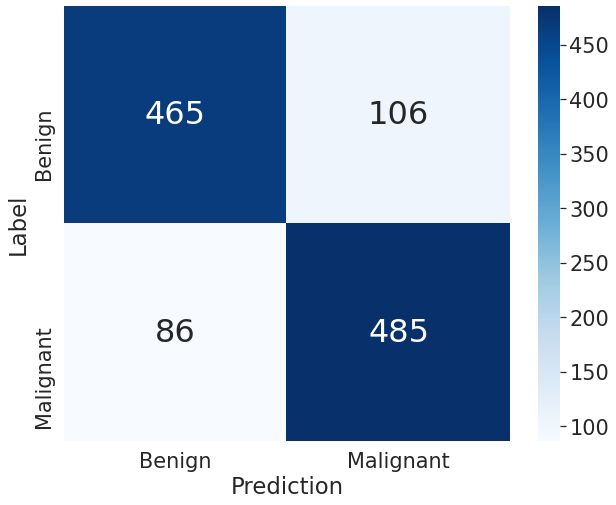

In [27]:
# Print confusion matrix
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=['Benign','Malignant'], yticklabels=['Benign','Malignant'], annot=True, annot_kws={"size": 32}, fmt='g', cmap='Blues')
sns.set(font_scale=1.9)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
